In [1]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()

# Para interpolar
import scipy.interpolate
from scipy.interpolate import griddata

# Para hacer animaciones
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
plt.rcParams["animation.html"] = "jshtml"

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Se define el dominio espacio-temporal
spacedomain = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(spacedomain, timedomain)

# Medio homogeneo de velocidad constante
v=1
# Se define la ecuación diferencial que se pueda leer en tensorflow
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_tt = dde.grad.hessian(y, x, i=1, j=1)
    f = tf.math.exp(-3*x[:,1:])*tf.math.sin(x[:,0:1])
    return dy_tt - v**2 * dy_xx - f

# y es la funcion u
# j=0 la primera variable es x y j=1 es la segunda variable t, por como se escribieron en la geometría

# Se definen las condiciones iniciales
def func(x):
    xc=0.2
    sigma=0.06
    return np.exp(-((x[:,0:1]-xc)/sigma)**2)
    # return np.sin(np.pi * x[:,0:1])*np.exp(-x[:,1:])

# the first component(x[:,0:1]) is x and the second component (x[:,1:]) is t

# Condición inicial de la posición
ic_1 = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
# Condición inicial de la velocidad
ic_2 = dde.icbc.OperatorBC(
    geomtime,
    lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=1),
    lambda x, _: dde.utils.isclose(x[1], 0),
)


# Y las condiciones de frontera
#bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary) # Condiciones de Dirichlet iguales a una función
bc = dde.icbc.NeumannBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary) # Condiciones de Neumann iguales a cero

# Se definen los datos de entrenamiento
#data = dde.data.TimePDE(geomtime,pde,[bc,ic],num_domain=4000,num_boundary=2000,num_initial=1000,solution=func,num_test=1000)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic_1, ic_2],
    num_domain=360,
    num_boundary=360,
    num_initial=360,
    solution=func,
    num_test=1000,
)

# Se define la arquitectura de la red neuronal FNN
layer_size = [2] + [20]*2 + [1]
activation="tanh"
initializer = "Glorot uniform"
optimizer = "adam"
net=dde.maps.FNN(layer_size,activation,initializer)


# Se define el modelo y se compila
model=dde.Model(data, net)
model.compile(optimizer, lr=0.001, metrics=["l2 relative error"])

# Se entrena la red
losshistory, train_state = model.train(iterations=15000)
model.compile("L-BFGS") # Se cambia el metodo de optimización y se sigue entrenando
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.064570 s



C:\Users\CESAR\anaconda3\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.677361 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [1.32e-01, 3.04e-02, 9.82e-02, 1.88e-01]    [4.14e-02, 3.04e-02, 9.82e-02, 1.88e-01]    [1.64e+00]    
1000      [4.96e-04, 3.13e-03, 5.81e-02, 6.52e-05]    [4.64e-04, 3.13e-03, 5.81e-02, 6.52e-05]    [9.51e-01]    
2000      [6.14e-04, 3.11e-03, 5.57e-02, 2.95e-04]    [6.59e-04, 3.11e-03, 5.57e-02, 2.95e-04]    [9.39e-01]    
3000      [7.11e-04, 1.95e-03, 4.93e-02, 3.22e-05]    [7.75e-04, 1.95e-03, 4.93e-02, 3.22e-05]    [9.62e-01]    
4000      [1.45e-04, 7.67e-04, 4.83e-02, 2.04e-04]    [2.47e-04, 7.67e-04, 4.83e-02, 2.04e-04]    [9.85e-01]    
5000      [8.61e-05, 2.71e-04, 4.75e-02, 3.04e-05]    [1.66e-04, 2.71e-04, 4.75e-02, 3.04e-05]    [1.00e+00]    
6000      [6.79e-05, 4.13e-04, 4.70e-02, 5.23e-05]    [1.48e-04, 4.13e-04, 4.70e-02, 5.23e-05]    [9.98e-01]    
7000      [7.00e-05, 4.36e-04, 4.68e-02, 5.49e-05]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (23,) + inhomogeneous part.

snapshots at: [1, 80, 160, 240, 320, 400]


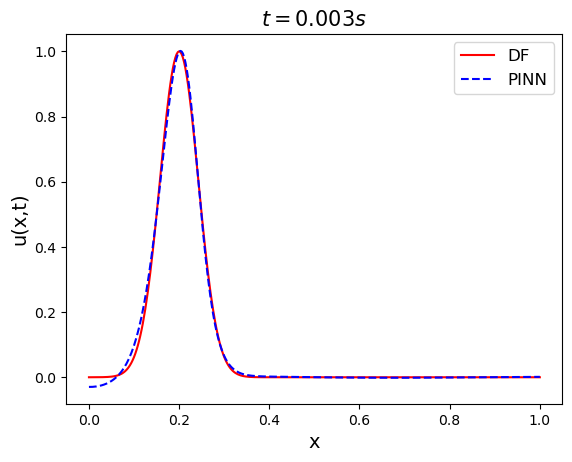

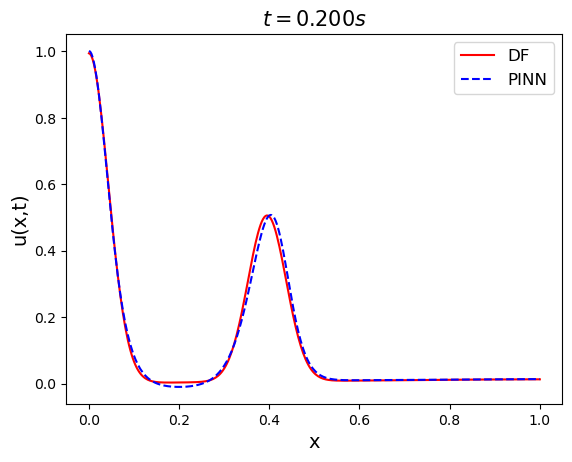

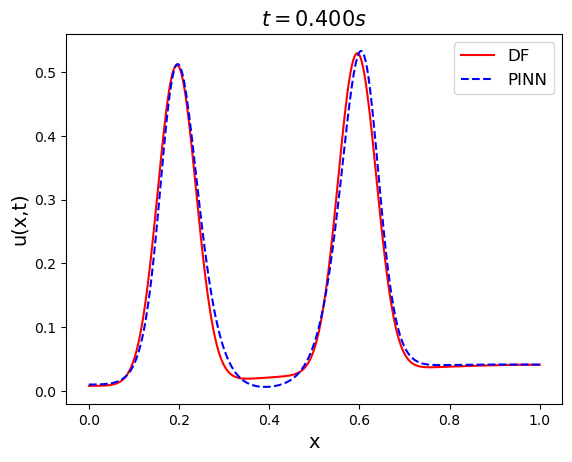

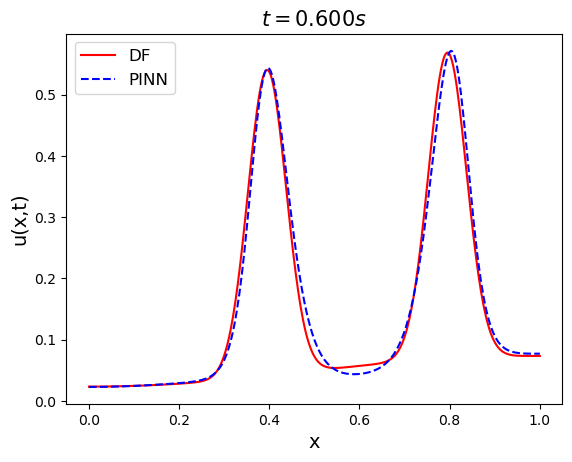

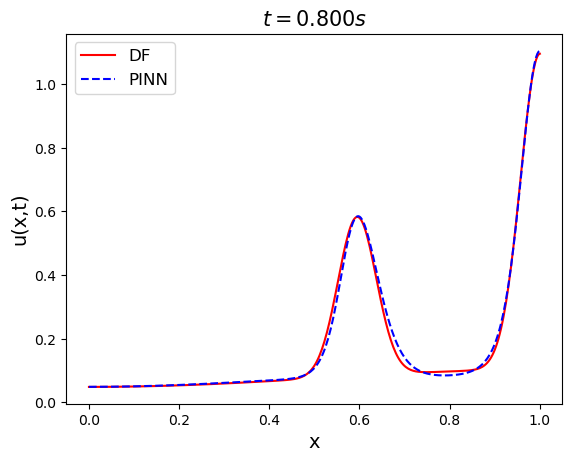

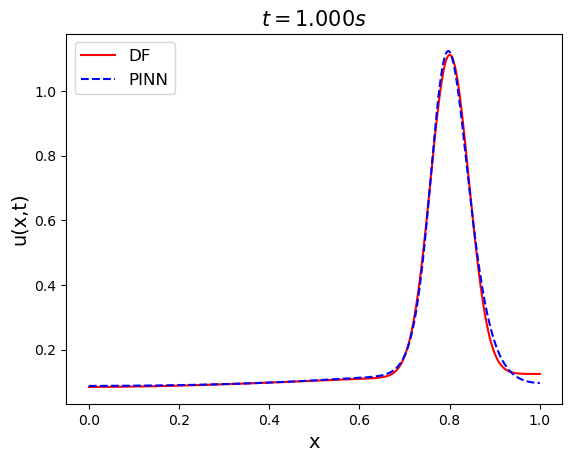

In [3]:
data3 = np.load("dataset/EcOnda1D_F_BCN.npz")
t, x, exact = data3["t"], data3["x"], data3["sol"].T
x1 = x
t1 = t
xx1, tt1 = np.meshgrid(x1, t1)
X1 = np.vstack((np.ravel(xx1), np.ravel(tt1))).T
u_pred1SC = model.predict(X1)


#predicted_solution=model.predict(test_domain)
#residual=model.predict(test_domain,operator=pde)

X_star1 = np.hstack((xx1.flatten()[:,None], tt1.flatten()[:,None]))
U_pred1SC = griddata(X_star1, u_pred1SC.flatten(), (xx1, tt1), method='cubic')

snaps_num = 5      # without first and last

snaps = [1]        #first slice

for k in range(1,snaps_num):
    snaps += [int(k*(len(t1)/snaps_num))]

snaps += [int(len(t1)-1)] #last slice

print("snapshots at:", snaps)

for snap in snaps:
    exa = plt.plot(x1,exact[snap-1,:],'r-', label = 'DF')
    pred = plt.plot(x1,U_pred1SC[snap,:],'b--', label = 'PINN')
    plt.title('$t = %1.3f s$ '%(t[snap]), fontsize = 15)
    plt.xlabel('x', fontsize = 14)
    plt.ylabel('u(x,t)', fontsize = 14)
    plt.legend(prop={'size':12})
    #plt.savefig('EcOnda1D_NN'+str(snap))
    plt.show()

In [ ]:
fig = plt.figure(3)
ax = fig.add_subplot(111)

def animate(i):
    ax.clear()
    ax.plot(x1,exact[i-1,:],'r-', label = 'FD')
    ax.plot(x1,U_pred1SC[i,:],'b--', label = 'PINN')
    ax.set_title('$t = %1.3f s$ '%(t[i]), fontsize = 15)
    ax.set_xlabel('x', fontsize = 10)
    ax.set_ylabel('u(x,t)', fontsize = 10)
    
anim = FuncAnimation(fig, animate, range(1,len(t1)-1), interval=100)
plt.show()
anim.save('Onda 1D DF No Homogeneo Caso 1.gif')